In [5]:
%matplotlib inline
import matplotlib.pylab as plt
import matplotlib.path as mplPath
import tables
import pandas as pd
import numpy as np

from tierpsy_features.helper import DataPartition
from tierpsy_features.features import get_timeseries_features
from tierpsy_features.summary_stats import get_time_groups, events_from_df


from tierpsy.analysis.feat_init.smooth_skeletons_table import read_food_contour

import os
base_dir = '/Users/ajaver/OneDrive - Imperial College London/tierpsy_features/test_data/multiworm'

#skeletons_file = os.path.join(base_dir, 'N2_worms10_CSCD563206_10_Set9_Pos4_Ch6_25072017_214236_skeletons.hdf5')
#skeletons_file = os.path.join(base_dir, 'N2_worms10_CSCD438313_10_Set12_Pos5_Ch4_25072017_223347_skeletons.hdf5')
skeletons_file = os.path.join(base_dir, 'MY23_worms5_food1-10_Set4_Pos5_Ch4_29062017_140148_skeletons.hdf5')
#skeletons_file = os.path.join(base_dir, '170817_matdeve_exp7co1_12_Set0_Pos0_Ch1_17082017_140001_skeletons.hdf5')

features_file = skeletons_file.replace('_skeletons.hdf5', '_featuresN.hdf5')

food_cnt = read_food_contour(features_file)/10
with pd.HDFStore(features_file, 'r') as fid:
    trajectories_data = fid['/trajectories_data']
    fps = fid.get_storer('/trajectories_data').attrs['fps']
    timeseries_features = fid['/timeseries_features']
    

event_df, event_durations = events_from_df(timeseries_features, fps)
    
print(trajectories_data.columns)
trajectories_data = trajectories_data[trajectories_data['skeleton_id']>-1]
trajectories_data_g = trajectories_data.groupby('worm_index_joined')



Index(['timestamp_raw', 'timestamp_time', 'worm_index_joined', 'coord_x',
       'coord_y', 'threshold', 'roi_size', 'area', 'frame_number',
       'was_skeletonized', 'skeleton_id', 'old_trajectory_data_index'],
      dtype='object')


dict_keys([3, 196])
0.1    -201.604227
0.9    2979.023267
Name: dist_from_food_edge, dtype: float64


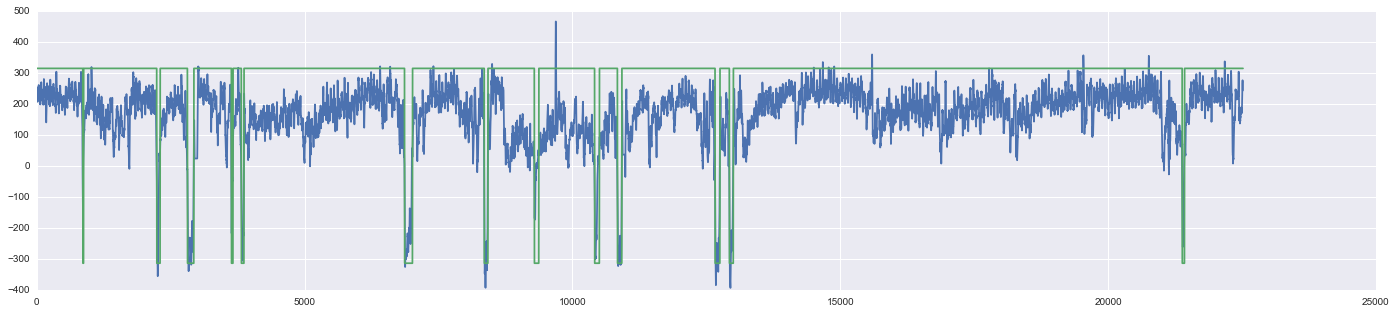

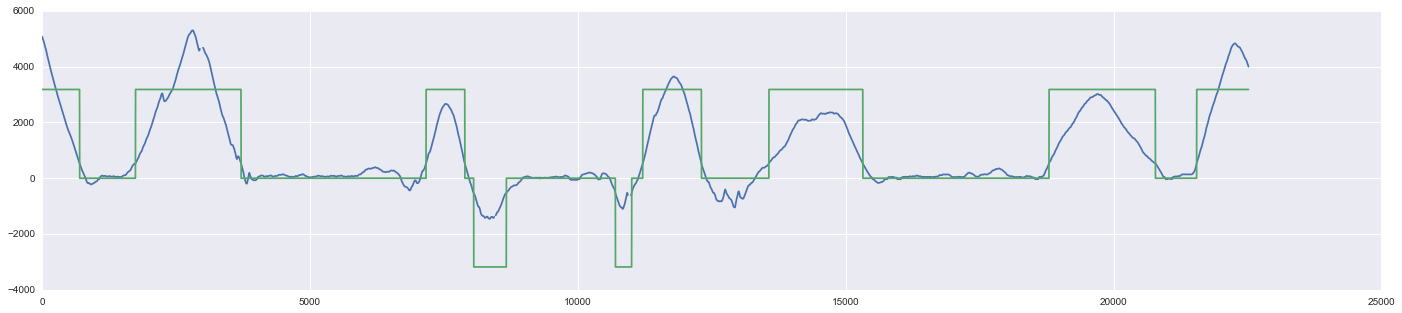

In [6]:
print(trajectories_data_g.groups.keys())
worm_index = 3#695

worm_data = trajectories_data_g.get_group(worm_index)
skel_id = worm_data['skeleton_id'].values 
with tables.File(features_file, 'r') as fid:
    skeletons = fid.get_node('/coordinates/skeletons')[skel_id, :, :]

timeseries_features_w = timeseries_features.loc[worm_data.index]
event_df_w = event_df.loc[worm_data.index]  


plt.figure(figsize=(24,5))
dd = timeseries_features_w['speed'].quantile([0.1, 0.9])
plt.plot(timeseries_features_w['speed'])
tt = (event_df_w['motion_mode']*(dd[0.9] + dd[0.1]))
plt.plot(tt)


plt.figure(figsize=(24,5))

plt.plot(timeseries_features_w['dist_from_food_edge'])
dd = timeseries_features_w['dist_from_food_edge'].quantile([0.1, 0.9])
print(dd)
tt = (event_df_w['food_region']*(dd[0.9] - dd[0.1]))
plt.plot(tt)


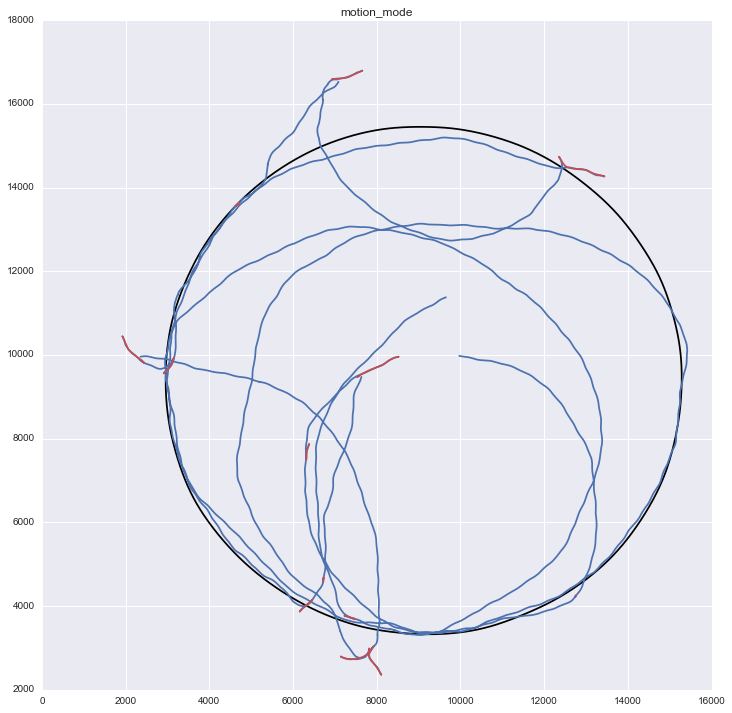

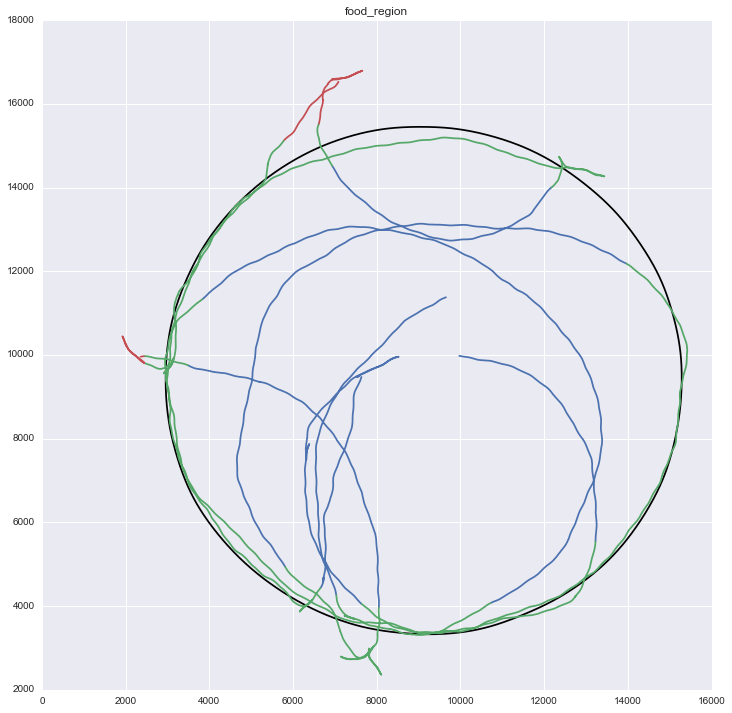

In [52]:
from tierpsy_features.velocities import _h_segment_position
get_unit_vec = lambda x : x/np.linalg.norm(x, axis=1)[:, np.newaxis]

worm_coords, orientation_v = _h_segment_position(skeletons, partition = 'body')

for event_t in ['motion_mode', 'food_region']:

    plt.figure(figsize=(12,12))
    plt.plot(food_cnt[:,0], food_cnt[:,1], 'k')
    for mod in [1, 0, -1]:
        cords = worm_coords.copy()

        cords[(event_df_w[event_t] != mod).values] = np.nan
        plt.plot(cords[:,0], cords[:,1])
    plt.title(event_t)

    